re_estimate_ggmFitHtf

In [1]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem

In [5]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [6]:
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


re-estimate the 12 session x 2 subjects x 12 trial using ggmFitHtf

In [7]:
# load pcorr_subj from the subjects model
data = loadmat('..\Pcorr_subject_level\pcorr_subj.mat')
pcorr_subj = data['pcorr']

In [8]:
# organize file in time sequence
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)
# file directory of the pcorr output for each session
filedir="../Pcorr_trial_level/" 
pathname = 'pcorr/'
dir=filedir+pathname

In [29]:
re_parcor_all=np.zeros([12,12,2,30,32,32])
iter_all=np.zeros([12,12,2,30])

for ses in range(12):
	filename='clean_'+str(filedates[ses])+'_pcorr.mat'
	spectral=loadmat(dir+filename)
	ampcorr = spectral['empirical_amplitude_correlation']
	for trl in range(12):
		for subj in range(2):
			for freq in range(30):
				# single trial in one session
				S = ampcorr[subj,trl,freq,:,:]
				# subject model
				x = pcorr_subj[subj, ses, freq,:,:]
				G = x.astype('bool')
				G = G.astype('int')
				# re-estimate
				precMat,iter = ggmFitHtf(S, G, maxIter=100)
				y = np.diag(precMat)
				yy = np.outer(y,y)
				yy = np.sqrt(yy)
				parcor = precMat/yy 
				re_parcor_all[ses,trl,subj,freq,:,:]=parcor
				iter_all[ses,trl,subj,freq]=iter

# takes 2 min on my HP laptop	
								

In [30]:
# save
outdict=dict()
outdict['re_parcor_all']=re_parcor_all
outdict['iter_all']=iter_all
savemat('re_estimate',outdict,store_python_metadata=True)

examine natural freq in each subject

In [36]:
# load 
outdict=loadmat('re_estimate.mat')
re_parcor_all=outdict["re_parcor_all"]
iter_all=outdict["iter_all"]
del(outdict)

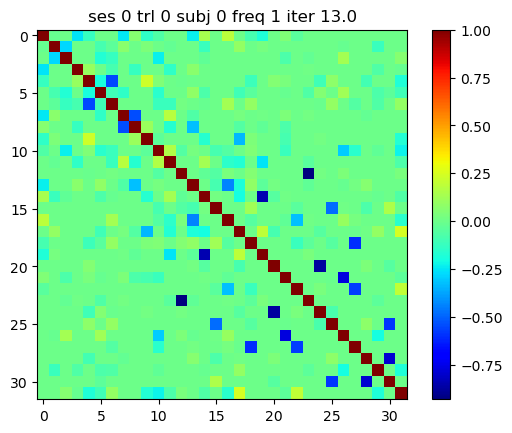

In [42]:
for ses in range(0,1):
	for trl in range(0,1):
		for subj in range(0,1):
			for freq in range(0,1):
				re_parcorr=re_parcor_all[ses,trl,subj,freq,:,:]
				iter=iter_all[ses,trl,subj,freq]
				plt.imshow(re_parcorr,cmap='jet'); plt.colorbar()
				plt.title('ses '+str(ses)+' trl '+str(trl)+\
	      			' subj '+str(subj)+ ' freq '+str(freq+1)+' iter '+str(iter))

